In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import torchfile
import numpy as np
import pandas as pd

/Users/yogesh/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [45]:
from skimage.transform import resize
from skimage import io
# All image transformations here

def imResize(img):
    return resize(img, (48, 48))

images = []
labels = []
trainData = torchfile.load('data/train.t7')
testData = torchfile.load('data/test.t7')

# Refer for index values (lua arrays are 1-indexed, so this is 1 less)
# classId, track, file = r[8], r[0], r[1]
# For labels
#dataset[idx][8]
# Ref legend:
# 0: track; 1: fileName; 2: Width; 3: Height;
# 4: X1; 5: Y1; 6: X2; 7: Y2; 8: label
prefix = 'data/train_images/'
img_dict = dict()
for row in trainData[:1000]:
    classId, track, fileName = row[8], row[0], row[1]
    x1, y1, x2, y2 = row[4], row[5], row[6], row[7]
    pathName = prefix + '%05d/%05d_%05d.ppm' % (classId, track, fileName)
    img = io.imread(pathName)
    #io.imshow(img)
    # Crop image on bounding box
    img_crop = img[x1:x2+2, y1:y2+2]
    images.append(imResize(img))
    labels.append(classId)
# Get numpy arrays
images_a = np.asarray(images)
#np.save('data/tr_images_32', images_a)
#np.save('data/tr_labels', labels_a)

In [55]:
tr_size = int(len(images_a)*0.9)
indices = np.random.permutation(images_a.shape[0])
training_idx, test_idx = indices[:tr_size], indices[tr_size:]
X_train, X_valid = images_a[training_idx,:], images_a[test_idx,:]
Y_train, Y_valid = [labels[i] for i in training_idx], [labels[i] for i in test_idx]
Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)

In [59]:
testData = torchfile.load('data/test.t7')
text_file = open("outputs/simple_cNN.csv", "w")
text_file.write("Filename,ClassId\n")
for img in X_test:

array([1000,   43,   51,    5,    6,   38,   46], dtype=int32)

In [2]:
# Load the saved numpy image here
x_train = np.load('data/tr_images_32.npy')
y_train = np.load('data/tr_labels.npy')

In [3]:
# Running a simple convnet model on the original dataset
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


In [28]:
batch_size = 32
nb_classes = 43
nb_epoch = 200
data_augmentation = False
img_rows, img_cols = 32, 32
# the CIFAR10 images are RGB
img_channels = 3
Y_train = np_utils.to_categorical(y_train, nb_classes)[:1000]
X_train = x_train[:1000]

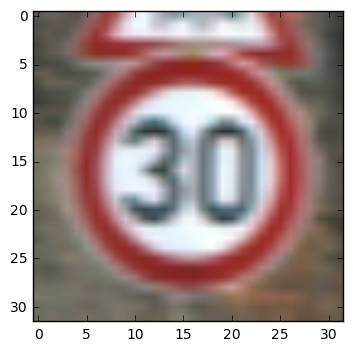

In [31]:
X_train.shape[1:]

(32, 32, 3)

In [13]:
model = Sequential()

model.add(Dense(128, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.add(Convolution2D(32, 5, 5, border_mode='same',
                        input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [14]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd, metrics=['accuracy'])

In [27]:
#model.fit(X_train, Y_train,
#              batch_size=batch_size,
#              nb_epoch=nb_epoch,
#              validation_split=0.1,
#              shuffle=True)

In [30]:
### Separating validation set
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train_images/00000/00000_00000.ppm')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='0', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely